In [1]:
import pandas as pd 
df = pd.read_csv("cc3m_full_with_path.csv")

In [2]:
df

,url,key,status,width,height,exif,caption,alt_txt,path
0,https://ak0.picdn.net/shutterstock/videos/3380...,1470004,success,852.0,480.0,{},the effect of moving the large colored particl...,"""""",/home/temp/Desktop/ccm3_full/00147/001470004.jpg
1,https://ak9.picdn.net/shutterstock/videos/2377...,1470024,success,852.0,480.0,{},wing of an airplane passing over clouds at hig...,"""""",/home/temp/Desktop/ccm3_full/00147/001470024.jpg
2,https://ak7.picdn.net/shutterstock/videos/1292...,1470042,success,852.0,480.0,{},man holding the keys to her new car in a motor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470042.jpg
3,https://ak9.picdn.net/shutterstock/videos/1147...,1470044,success,852.0,480.0,{},background with particles and stars .,"""""",/home/temp/Desktop/ccm3_full/00147/001470044.jpg
4,https://ak8.picdn.net/shutterstock/videos/5176...,1470039,success,852.0,480.0,{},food canned in mason jars on shelves in a stor...,"""""",/home/temp/Desktop/ccm3_full/00147/001470039.jpg
...,...,...,...,...,...,...,...,...,...
2555423,http://l7.alamy.com/zooms/5f24d20339df4077a506...,2199920,success,640.0,447.0,{},senior woman in the park,"""""",/home/temp/Desktop/ccm3_full/00219/002199920.jpg
2555424,http://l7.alamy.com/zooms/7c2ad41134dc4b1984d9...,2199914,success,640.0,446.0,{},remote house in the forest by lake,"""""",/home/temp/Desktop/ccm3_full/00219/002199914.jpg
2555425,http://l7.alamy.com/zooms/0dd49ace792a4db6be39...,2199999,success,640.0,448.0,{},wind blown tree on the beach,"""""",/home/temp/Desktop/ccm3_full/00219/002199999.jpg
2555426,http://l7.alamy.com/zooms/28f1e935be484181a90c...,2199994,success,640.0,447.0,{},snow covered city park in a winter day .,"""""",/home/temp/Desktop/ccm3_full/00219/002199994.jpg


In [1]:
from dataset import * 
from tqdm import tqdm 

/home/temp/miniconda3/envs/stanford_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision import datasets, transforms
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
        transforms.Resize((32, 32))
    ])
dataset = MnistTesting(transform, transform)

In [3]:
from PIL import ImageFont, ImageDraw, Image 

def render_text(txt:str, image_size: int=224, font_size: int = 16, max_chars=768,
                       background_brightness=127, text_brightness=0,
                       lower=True, monospace=False, spacing=1, min_width=4,
                       resize_method="area", max_width=28):
    if len(txt)> max_chars:
        txt = txt[:max_chars]
    if lower: 
        txt = txt.lower() 
    wrapper = textwrap.TextWrapper(width=max_width)
    lines = wrapper.wrap(txt) 
    new_txt = ""
    for line in lines: 
        new_txt+= line+'\n'
    image = Image.new("RGBA", (image_size*3,image_size*3), (background_brightness,background_brightness,background_brightness))
    draw = ImageDraw.Draw(image)
    font = ImageFont.truetype("/home/temp/Desktop/CLIPPO/unifont-15.0.06.otf", font_size*3)
    draw.text((0, 0), new_txt, (text_brightness,text_brightness,text_brightness), font=font, spacing=spacing)
    img_resized = image.resize((image_size,image_size), Image.ANTIALIAS)
    return img_resized


In [9]:
import torch 
from network import CLIPPO
from tim_and_bert import * 
clippo = CLIP()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("/home/temp/Desktop/KD/CLIPPO/clippo_2k.pt")) 

RuntimeError: Error(s) in loading state_dict for CLIP:
	Missing key(s) in state_dict: "image_encoder.encoder.conv1.weight", "image_encoder.encoder.bn1.weight", "image_encoder.encoder.bn1.bias", "image_encoder.encoder.bn1.running_mean", "image_encoder.encoder.bn1.running_var", "image_encoder.encoder.layer1.0.conv1.weight", "image_encoder.encoder.layer1.0.bn1.weight", "image_encoder.encoder.layer1.0.bn1.bias", "image_encoder.encoder.layer1.0.bn1.running_mean", "image_encoder.encoder.layer1.0.bn1.running_var", "image_encoder.encoder.layer1.0.conv2.weight", "image_encoder.encoder.layer1.0.bn2.weight", "image_encoder.encoder.layer1.0.bn2.bias", "image_encoder.encoder.layer1.0.bn2.running_mean", "image_encoder.encoder.layer1.0.bn2.running_var", "image_encoder.encoder.layer1.1.conv1.weight", "image_encoder.encoder.layer1.1.bn1.weight", "image_encoder.encoder.layer1.1.bn1.bias", "image_encoder.encoder.layer1.1.bn1.running_mean", "image_encoder.encoder.layer1.1.bn1.running_var", "image_encoder.encoder.layer1.1.conv2.weight", "image_encoder.encoder.layer1.1.bn2.weight", "image_encoder.encoder.layer1.1.bn2.bias", "image_encoder.encoder.layer1.1.bn2.running_mean", "image_encoder.encoder.layer1.1.bn2.running_var", "image_encoder.encoder.layer2.0.conv1.weight", "image_encoder.encoder.layer2.0.bn1.weight", "image_encoder.encoder.layer2.0.bn1.bias", "image_encoder.encoder.layer2.0.bn1.running_mean", "image_encoder.encoder.layer2.0.bn1.running_var", "image_encoder.encoder.layer2.0.conv2.weight", "image_encoder.encoder.layer2.0.bn2.weight", "image_encoder.encoder.layer2.0.bn2.bias", "image_encoder.encoder.layer2.0.bn2.running_mean", "image_encoder.encoder.layer2.0.bn2.running_var", "image_encoder.encoder.layer2.0.downsample.0.weight", "image_encoder.encoder.layer2.0.downsample.1.weight", "image_encoder.encoder.layer2.0.downsample.1.bias", "image_encoder.encoder.layer2.0.downsample.1.running_mean", "image_encoder.encoder.layer2.0.downsample.1.running_var", "image_encoder.encoder.layer2.1.conv1.weight", "image_encoder.encoder.layer2.1.bn1.weight", "image_encoder.encoder.layer2.1.bn1.bias", "image_encoder.encoder.layer2.1.bn1.running_mean", "image_encoder.encoder.layer2.1.bn1.running_var", "image_encoder.encoder.layer2.1.conv2.weight", "image_encoder.encoder.layer2.1.bn2.weight", "image_encoder.encoder.layer2.1.bn2.bias", "image_encoder.encoder.layer2.1.bn2.running_mean", "image_encoder.encoder.layer2.1.bn2.running_var", "image_encoder.encoder.layer3.0.conv1.weight", "image_encoder.encoder.layer3.0.bn1.weight", "image_encoder.encoder.layer3.0.bn1.bias", "image_encoder.encoder.layer3.0.bn1.running_mean", "image_encoder.encoder.layer3.0.bn1.running_var", "image_encoder.encoder.layer3.0.conv2.weight", "image_encoder.encoder.layer3.0.bn2.weight", "image_encoder.encoder.layer3.0.bn2.bias", "image_encoder.encoder.layer3.0.bn2.running_mean", "image_encoder.encoder.layer3.0.bn2.running_var", "image_encoder.encoder.layer3.0.downsample.0.weight", "image_encoder.encoder.layer3.0.downsample.1.weight", "image_encoder.encoder.layer3.0.downsample.1.bias", "image_encoder.encoder.layer3.0.downsample.1.running_mean", "image_encoder.encoder.layer3.0.downsample.1.running_var", "image_encoder.encoder.layer3.1.conv1.weight", "image_encoder.encoder.layer3.1.bn1.weight", "image_encoder.encoder.layer3.1.bn1.bias", "image_encoder.encoder.layer3.1.bn1.running_mean", "image_encoder.encoder.layer3.1.bn1.running_var", "image_encoder.encoder.layer3.1.conv2.weight", "image_encoder.encoder.layer3.1.bn2.weight", "image_encoder.encoder.layer3.1.bn2.bias", "image_encoder.encoder.layer3.1.bn2.running_mean", "image_encoder.encoder.layer3.1.bn2.running_var", "image_encoder.encoder.layer4.0.conv1.weight", "image_encoder.encoder.layer4.0.bn1.weight", "image_encoder.encoder.layer4.0.bn1.bias", "image_encoder.encoder.layer4.0.bn1.running_mean", "image_encoder.encoder.layer4.0.bn1.running_var", "image_encoder.encoder.layer4.0.conv2.weight", "image_encoder.encoder.layer4.0.bn2.weight", "image_encoder.encoder.layer4.0.bn2.bias", "image_encoder.encoder.layer4.0.bn2.running_mean", "image_encoder.encoder.layer4.0.bn2.running_var", "image_encoder.encoder.layer4.0.downsample.0.weight", "image_encoder.encoder.layer4.0.downsample.1.weight", "image_encoder.encoder.layer4.0.downsample.1.bias", "image_encoder.encoder.layer4.0.downsample.1.running_mean", "image_encoder.encoder.layer4.0.downsample.1.running_var", "image_encoder.encoder.layer4.1.conv1.weight", "image_encoder.encoder.layer4.1.bn1.weight", "image_encoder.encoder.layer4.1.bn1.bias", "image_encoder.encoder.layer4.1.bn1.running_mean", "image_encoder.encoder.layer4.1.bn1.running_var", "image_encoder.encoder.layer4.1.conv2.weight", "image_encoder.encoder.layer4.1.bn2.weight", "image_encoder.encoder.layer4.1.bn2.bias", "image_encoder.encoder.layer4.1.bn2.running_mean", "image_encoder.encoder.layer4.1.bn2.running_var", "text_encoder.embedding.weight", "text_encoder.MLP.0.weight", "text_encoder.MLP.0.bias", "text_encoder.MLP.2.weight", "text_encoder.MLP.2.bias", "text_encoder.MLP.4.weight", "text_encoder.MLP.4.bias". 
	Unexpected key(s) in state_dict: "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.bn1.num_batches_tracked", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.bn1.num_batches_tracked", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.bn2.num_batches_tracked", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.bn1.num_batches_tracked", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.bn2.num_batches_tracked", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.bn1.num_batches_tracked", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.bn2.num_batches_tracked", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.0.downsample.1.num_batches_tracked", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.bn1.num_batches_tracked", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.bn2.num_batches_tracked", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.bn1.num_batches_tracked", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.bn2.num_batches_tracked", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.0.downsample.1.num_batches_tracked", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.bn1.num_batches_tracked", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.bn2.num_batches_tracked", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.bn1.num_batches_tracked", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.bn2.num_batches_tracked", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.0.downsample.1.num_batches_tracked", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.bn1.num_batches_tracked", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.bn2.num_batches_tracked", "text_proj.0.weight", "text_proj.0.bias", "text_proj.2.weight", "text_proj.2.bias", "image_proj.0.weight", "image_proj.0.bias", "image_proj.2.weight", "image_proj.2.bias". 

In [4]:
import torch 
from network import CLIPPO
from tim_and_bert import * 
clippo = CLIPPO()
clippo = clippo.cpu()
clippo.load_state_dict(torch.load("/home/temp/Desktop/KD/CLIPPO/clippo_2k_dino_.pt")) 

<All keys matched successfully>

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.decomposition import PCA

In [20]:
features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 2000, shuffle=False, num_workers=32)
for images, _, labels in valid_loader: 
    with torch.no_grad():
        #out,_= clippo(torch.tensor(labels).cuda(1), images.cuda(1))#.squeeze()
        out = clippo.image_proj(clippo.encoder(images.cuda(1))).squeeze()
        #out = clippo.logit_scale*out/ out.norm(dim=1, keepdim=True)
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

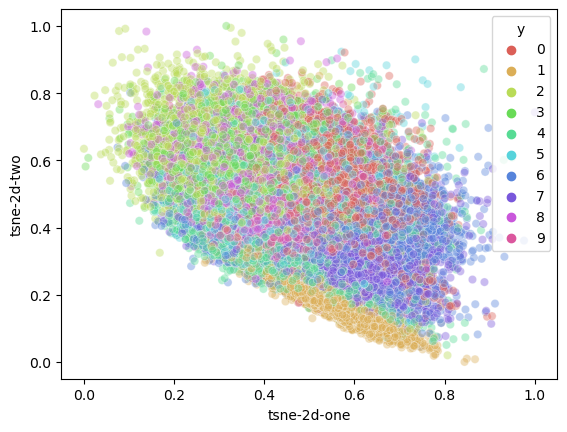

In [21]:
#tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = features[:, 0].squeeze(), features[:, 1].squeeze()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

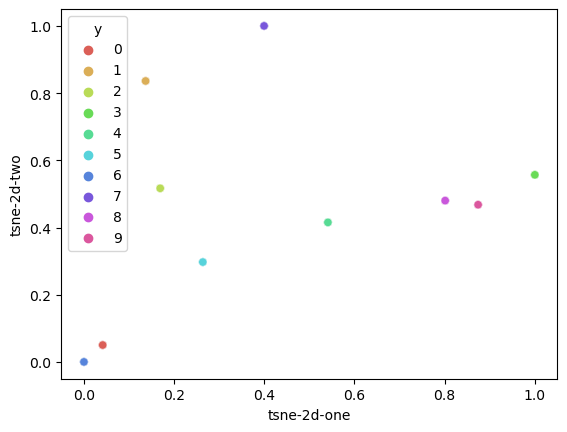

In [11]:
#tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = features[:, 0].squeeze(), features[:, 1].squeeze()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

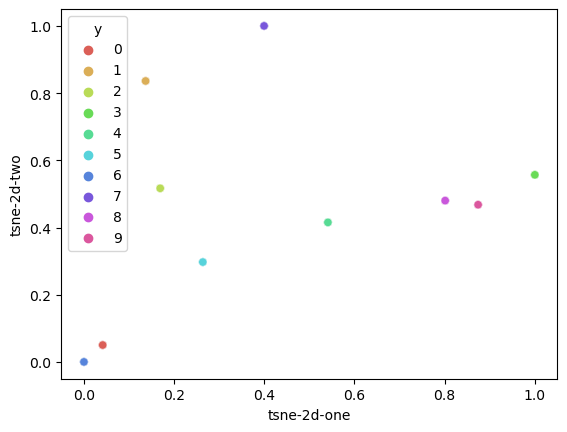

In [12]:
#tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = features[:, 0].squeeze(), features[:, 1].squeeze()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

In [ ]:
features = []
labels_ar = [] 
clippo = clippo.cuda(1)
clippo.eval() 
valid_loader = torch.utils.data.DataLoader(dataset, 2000, shuffle=False, num_workers=32)
for images, labels in valid_loader: 
    with torch.no_grad():
        #out,_= clippo(torch.tensor(labels).cuda(1), images.cuda(1))#.squeeze()
        out = clippo.text_proj(clippo.encoder(images.cuda(1))).squeeze()
        #out = clippo.logit_scale*out/ out.norm(dim=1, keepdim=True)
        features.append(out)
        labels_ar.append(labels[None, :])

features = torch.concat(features).cpu().detach().numpy()
labels_ar = torch.concat(labels_ar, dim=1).detach().numpy()

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

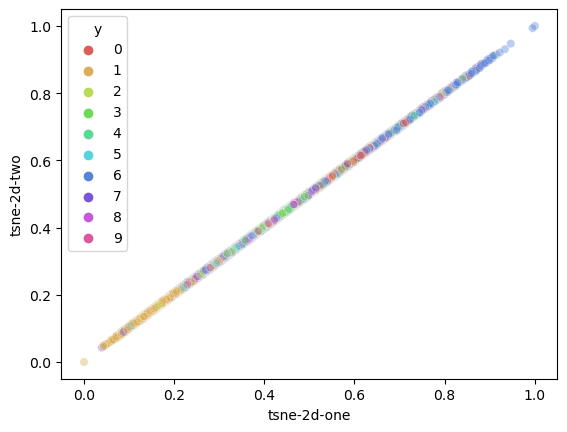

In [36]:
#tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = features[:, 0].squeeze(), features[:, 1].squeeze()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

In [13]:
#tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = features[:, 0].squeeze(), features[:, 1].squeeze()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

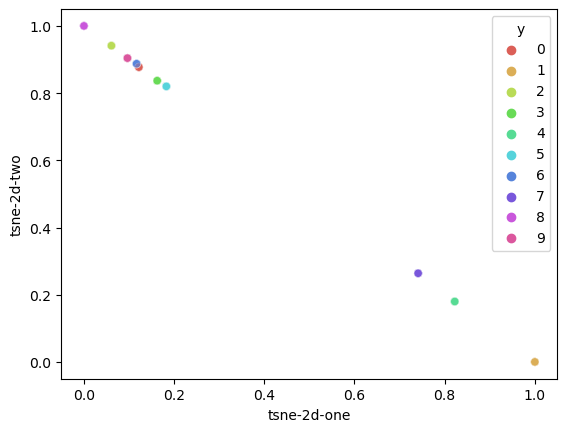

In [14]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

In [16]:
features[:, 1].squeeze().shape

(60000,)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

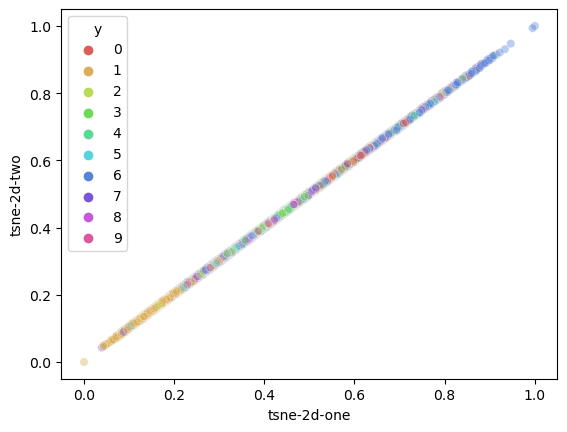

In [17]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

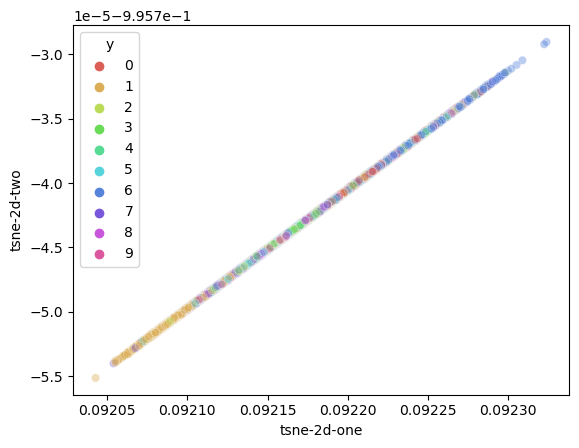

In [11]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':features[:, 0].squeeze(), 'tsne-2d-two':features[:, 1].squeeze(), 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

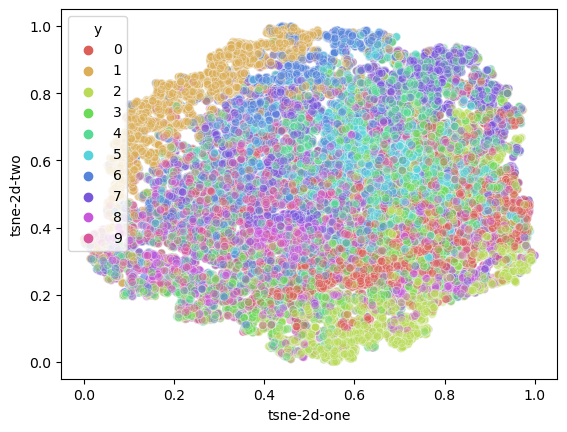

In [25]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

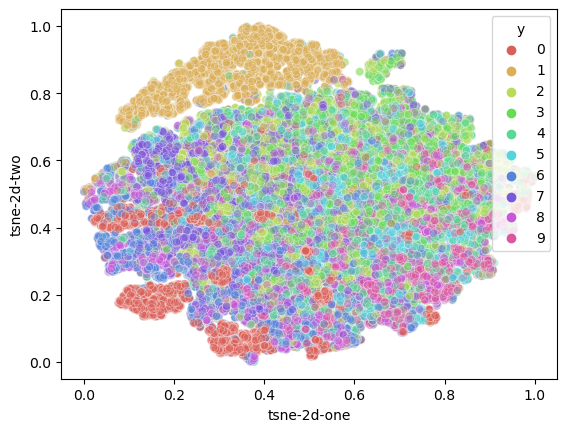

In [20]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.4
)

In [10]:
tsne = TSNE(n_jobs=-1).fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

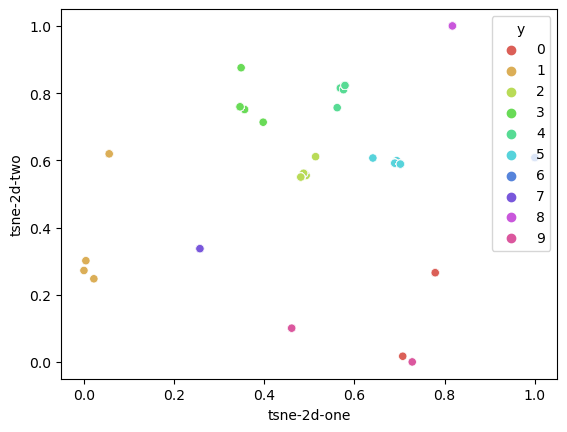

In [11]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

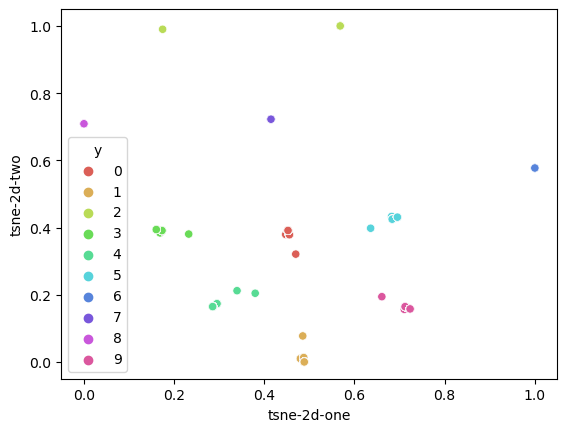

In [28]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=1
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

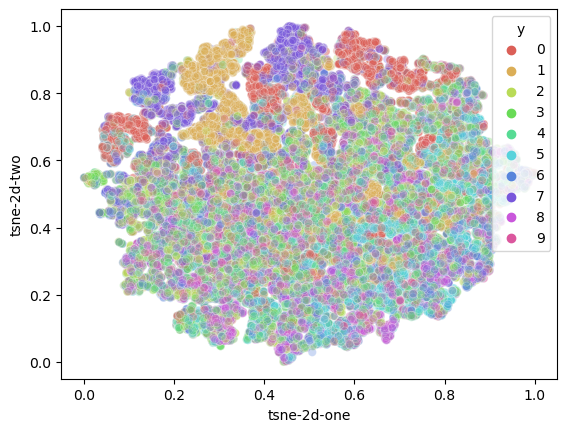

In [19]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

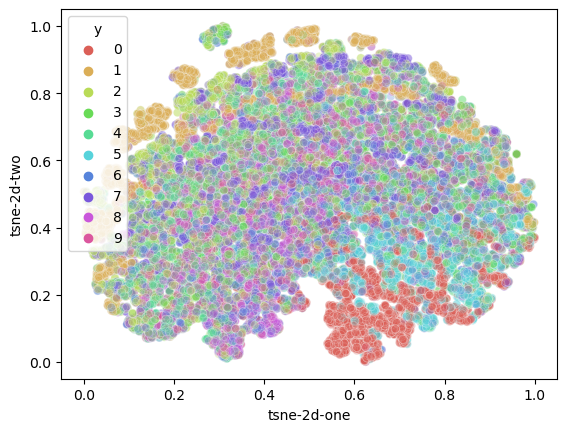

In [9]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

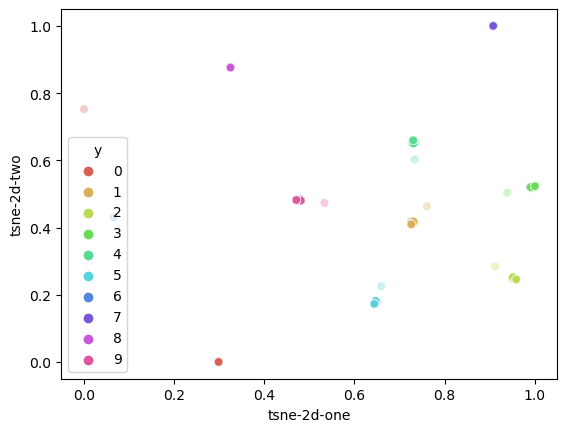

In [17]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.3
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

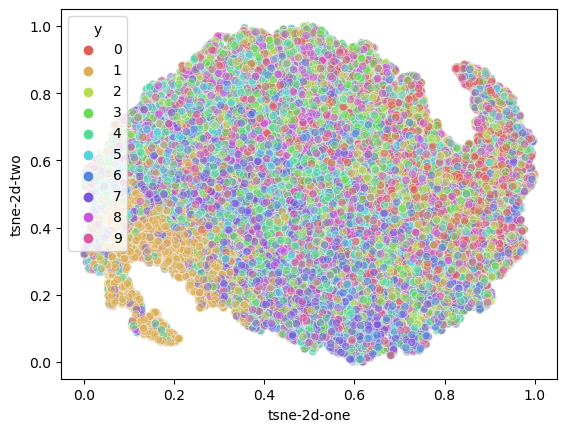

In [13]:
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pd.DataFrame({'tsne-2d-one':tx, 'tsne-2d-two':ty, 'y':labels_ar.squeeze()}),
    legend="full",
    alpha=0.5
)

In [15]:
labels_ar.shape

(1, 60000)

In [16]:
features.shape

(60000, 2)

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels_ar.squeeze(), test_size=0.33, random_state=42)

In [23]:
lr = RandomForestClassifier(min_samples_leaf=10, n_estimators=500, n_jobs=-1)

In [24]:
lr.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=10, n_estimators=500, n_jobs=-1)

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_tes, lr.predict(X_test))

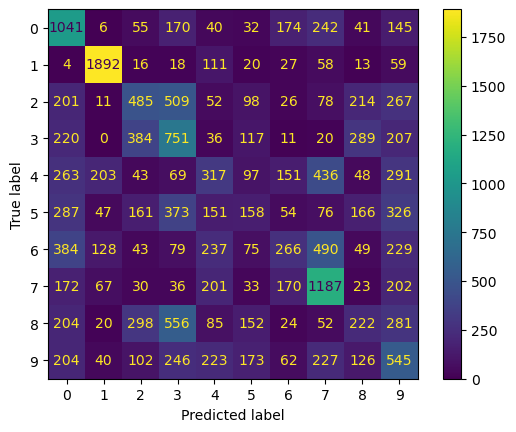

In [26]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

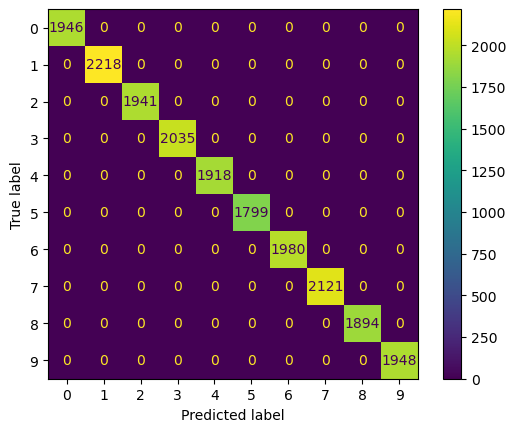

In [17]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

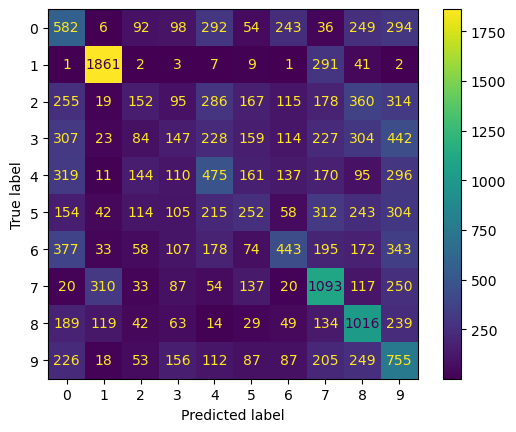

In [64]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

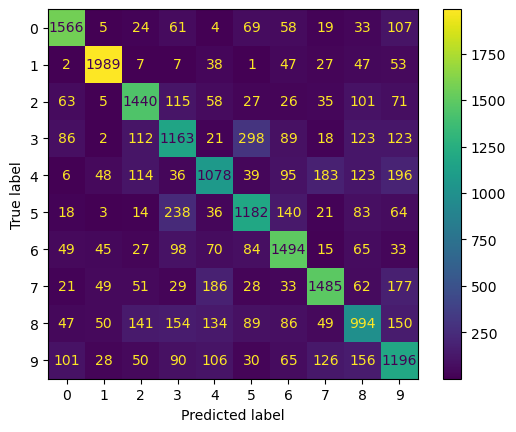

In [32]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

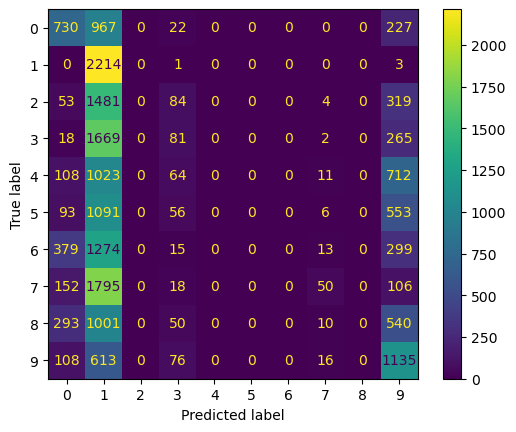

In [19]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

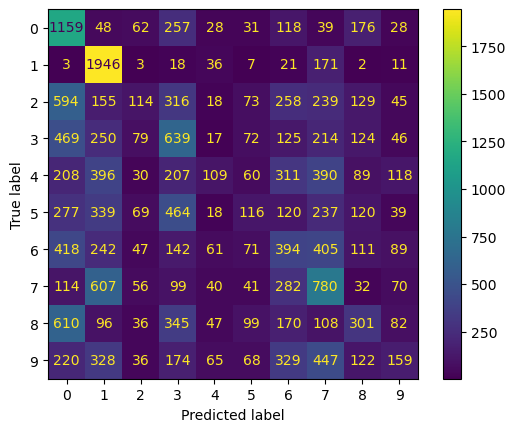

In [36]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)

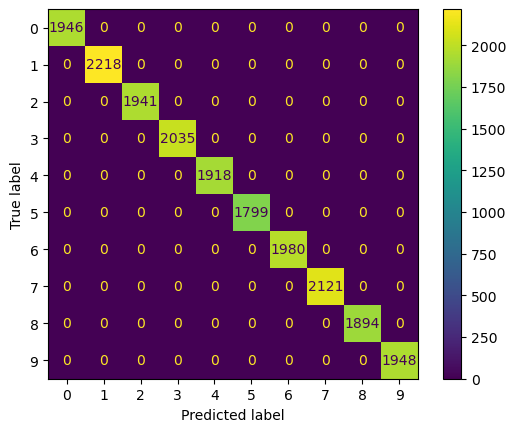

In [30]:
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test)